Iteración 1: cambio total en centroides = 3.126486
Iteración 2: cambio total en centroides = 0.126727
Iteración 3: cambio total en centroides = 0.034593
Iteración 4: cambio total en centroides = 0.049868
Iteración 5: cambio total en centroides = 0.047679
Iteración 6: cambio total en centroides = 0.131963
Iteración 7: cambio total en centroides = 0.454084
Iteración 8: cambio total en centroides = 1.521518
Iteración 9: cambio total en centroides = 2.411524
Iteración 10: cambio total en centroides = 0.062197
Iteración 11: cambio total en centroides = 0.000000
Convergencia alcanzada.

Dataset 1: K-means convergió en 11 iteraciones.
Centroides finales:
 [[ 4.03530049  3.98879264]
 [-0.04442848  4.98993008]
 [-0.0073731  -0.02307762]]


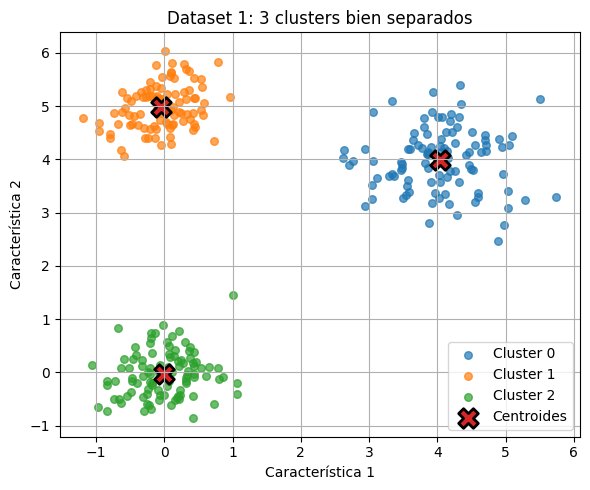

Iteración 1: cambio total en centroides = 2.166204
Iteración 2: cambio total en centroides = 0.694345
Iteración 3: cambio total en centroides = 0.636919
Iteración 4: cambio total en centroides = 1.292358
Iteración 5: cambio total en centroides = 2.598570
Iteración 6: cambio total en centroides = 1.539742
Iteración 7: cambio total en centroides = 0.114428
Iteración 8: cambio total en centroides = 0.000000
Convergencia alcanzada.

Dataset 2: K-means convergió en 8 iteraciones.
Centroides finales:
 [[-3.0046696   2.92206445]
 [ 3.03967033 -3.06293179]
 [ 3.1557194   2.98730763]
 [-2.95490462 -3.00011706]]


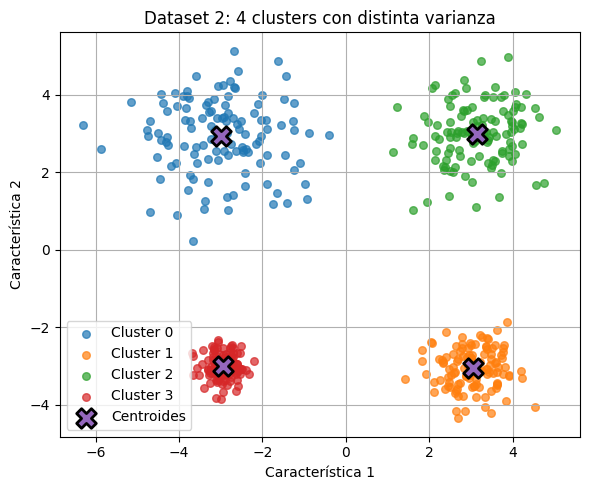

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1. Generación de datasets
# ==========================

def make_synthetic_clusters(centers, n_points_per_cluster=100, std=0.5, random_state=None):
    """
    Genera un dataset 2D tipo "blobs" a partir de centros dados.
    
    Parameters
    ----------
    centers : list of tuple
        Lista de centros, por ejemplo [(0,0), (3,3), (-3,2)].
    n_points_per_cluster : int
        Número de puntos por cada cluster.
    std : float or list
        Desviación estándar de la nube de puntos alrededor de cada centro.
        Puede ser:
        - float: misma std para todos
        - list del mismo tamaño que centers: std diferente por centro
    random_state : int or None
        Semilla para reproducibilidad.
    
    Returns
    -------
    X : np.ndarray, shape (n_points, 2)
        Puntos generados.
    y_true : np.ndarray, shape (n_points,)
        Etiquetas verdaderas de cluster (0,1,2,...).
    """
    rng = np.random.default_rng(random_state)
    
    centers = np.array(centers)
    k = len(centers)
    
    if isinstance(std, (int, float)):
        std = [std] * k
    std = np.asarray(std)
    
    all_points = []
    all_labels = []
    for idx, (cx, cy) in enumerate(centers):
        # Generamos puntos alrededor del centro (cx, cy)
        points = rng.normal(loc=[cx, cy], scale=std[idx], size=(n_points_per_cluster, 2))
        all_points.append(points)
        all_labels.append(np.full(n_points_per_cluster, idx, dtype=int))
    
    X = np.vstack(all_points)
    y_true = np.concatenate(all_labels)
    return X, y_true


# ==========================
# 2. Implementación de K-means
# ==========================

def initialize_centroids(X, k, random_state=None):
    """
    Inicializa los centroides eligiendo k puntos aleatorios del dataset.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Datos.
    k : int
        Número de clusters.
    random_state : int or None
        Semilla para reproducibilidad.
    
    Returns
    -------
    centroids : np.ndarray, shape (k, n_features)
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    
    # Elegimos k índices distintos aleatorios
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices]
    return centroids


def compute_distances(X, centroids):
    """
    Calcula la distancia Euclidiana de cada punto a cada centroide.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    centroids : np.ndarray, shape (k, n_features)
    
    Returns
    -------
    distances : np.ndarray, shape (n_samples, k)
        distances[i, j] = distancia del punto i al centroide j
    """
    # Usamos broadcasting:
    # X: (n_samples, n_features)
    # centroids: (k, n_features)
    # X[:, None, :] -> (n_samples, 1, n_features)
    # centroids[None, :, :] -> (1, k, n_features)
    # Resultado de la resta: (n_samples, k, n_features)
    diff = X[:, None, :] - centroids[None, :, :]
    
    # Distancia Euclidiana: sqrt(sum(diff^2))
    distances = np.linalg.norm(diff, axis=2)  # (n_samples, k)
    return distances


def assign_clusters(X, centroids):
    """
    Asigna cada punto al centroide más cercano.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    centroids : np.ndarray, shape (k, n_features)
    
    Returns
    -------
    labels : np.ndarray, shape (n_samples,)
        Índice del centroide asignado para cada punto.
    """
    distances = compute_distances(X, centroids)
    # Tomamos el índice del centroide con menor distancia
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(X, labels, k):
    """
    Recalcula los centroides como el promedio de los puntos asignados a cada cluster.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    labels : np.ndarray, shape (n_samples,)
        Etiquetas de cluster para cada punto.
    k : int
        Número de clusters.
    
    Returns
    -------
    new_centroids : np.ndarray, shape (k, n_features)
    """
    n_features = X.shape[1]
    new_centroids = np.zeros((k, n_features))
    
    for cluster_idx in range(k):
        # Seleccionamos los puntos que pertenecen al cluster cluster_idx
        points_in_cluster = X[labels == cluster_idx]
        
        if len(points_in_cluster) == 0:
            # Caso raro: ningún punto asignado a este cluster.
            # Podemos dejar el centroide como está, o re-inicializar.
            # Aquí, para evitar NaNs, lo dejamos como 0 o podríamos manejarlo distinto.
            # En una implementación más robusta, lo re-inicializaríamos aleatoriamente.
            continue
        else:
            new_centroids[cluster_idx] = points_in_cluster.mean(axis=0)
    
    return new_centroids


def kmeans(X, k, max_iter=100, tol=1e-4, random_state=None, verbose=False):
    """
    Implementación básica de K-means.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    k : int
        Número de clusters.
    max_iter : int
        Máximo número de iteraciones.
    tol : float
        Tolerancia para el cambio entre centroides (criterio de parada).
    random_state : int or None
        Semilla para reproducibilidad.
    verbose : bool
        Si True, imprime información en cada iteración.
    
    Returns
    -------
    centroids : np.ndarray, shape (k, n_features)
        Centroides finales.
    labels : np.ndarray, shape (n_samples,)
        Asignación final de clusters.
    n_iter : int
        Número de iteraciones realizadas.
    """
    # 1. Inicializar centroides
    centroids = initialize_centroids(X, k, random_state=random_state)
    
    for it in range(max_iter):
        # 2. Asignar cada punto al centroide más cercano
        labels = assign_clusters(X, centroids)
        
        # 3. Calcular nuevos centroides
        new_centroids = update_centroids(X, labels, k)
        
        # 4. Comprobar convergencia (si los centroides casi no cambian)
        shift = np.linalg.norm(new_centroids - centroids)
        
        if verbose:
            print(f"Iteración {it+1}: cambio total en centroides = {shift:.6f}")
        
        if shift < tol:
            if verbose:
                print("Convergencia alcanzada.")
            centroids = new_centroids
            break
        
        centroids = new_centroids
    
    return centroids, labels, it + 1


# ==========================
# 3. Ejemplos aplicados
# ==========================

def plot_clusters(X, labels, centroids, title="Clusters encontrados"):
    """
    Gráfica 2D de los puntos y los centroides.
    Solo aplica si X tiene 2 características (columna 0 y 1).
    """
    plt.figure(figsize=(6, 5))
    
    k = centroids.shape[0]
    
    for cluster_idx in range(k):
        points = X[labels == cluster_idx]
        plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.7, label=f"Cluster {cluster_idx}")
    
    # Dibujar centroides
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        s=200,
        marker="X",
        edgecolor="black",
        linewidth=2,
        label="Centroides"
    )
    
    plt.title(title)
    plt.xlabel("Característica 1")
    plt.ylabel("Característica 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # =====================
    # Dataset 1: 3 clusters claros
    # =====================
    centers1 = [(0, 0), (4, 4), (0, 5)]
    X1, y_true1 = make_synthetic_clusters(
        centers=centers1,
        n_points_per_cluster=100,
        std=[0.5, 0.6, 0.4],
        random_state=42
    )
    
    k = 3
    centroids1, labels1, n_iter1 = kmeans(X1, k=k, max_iter=100, tol=1e-4, random_state=0, verbose=True)
    print(f"\nDataset 1: K-means convergió en {n_iter1} iteraciones.")
    print("Centroides finales:\n", centroids1)
    
    plot_clusters(X1, labels1, centroids1, title="Dataset 1: 3 clusters bien separados")
    
    # =====================
    # Dataset 2: 4 clusters con distintas dispersiones
    # =====================
    centers2 = [(-3, -3), (-3, 3), (3, -3), (3, 3)]
    X2, y_true2 = make_synthetic_clusters(
        centers=centers2,
        n_points_per_cluster=120,
        std=[0.3, 1.0, 0.5, 0.8],
        random_state=123
    )
    
    k2 = 4
    centroids2, labels2, n_iter2 = kmeans(X2, k=k2, max_iter=100, tol=1e-4, random_state=1, verbose=True)
    print(f"\nDataset 2: K-means convergió en {n_iter2} iteraciones.")
    print("Centroides finales:\n", centroids2)
    
    plot_clusters(X2, labels2, centroids2, title="Dataset 2: 4 clusters con distinta varianza")
